## RQ 2: What is the performance distribution given the respective achievement level of the pair programmers?

Investigation of debugging scores differences basing from achievement level groups 
- Determine each student’s achievement level by mean score -- when pre-test score is below the mean, the student will be tagged as a Low performer, and the otherwise High performer
- Assign pairs to three achievement level groups: High-High, High-Low, and Low-Low performers
- Assign the pair’s debugging score differences to the achievement level groups
- Investigate properties through distribution analysis


In [105]:
import pandas as pd
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [123]:
cols_classes = ['ArgCcl', 'ArgCnt', 'ArgCon', 'ArgEla', 'ArgRsn', 'EliOpn', 'EliPrp', 'EliSet', 'EliVer',
                'ImpAct', 'ImpFoc', 'InfAct', 'InfNeg', 'InfNeu', 'InfNon', 'InfPos', 'InfSoc', 'InfSol',
                'InfStm', 'ResCfm', 'ResDen','ResSol', 'ResStm']
class_group = ['Arg', 'Eli', 'Imp', 'Inf', 'Res']
cols_classes_groups = ['grp_' + grp for grp in class_group]
cols_tests = ['pre_test_score', 'self_efficacy', 'debugging_scores']

In [128]:
stud_df = pd.read_csv("data/proc/student_data.csv", index_col="student")

In [129]:
stud_df["static_or_dynamic"].value_counts()

Static     59
Dynamic    50
Name: static_or_dynamic, dtype: int64

In [137]:
# Assigning mean scores and performance level by static/dynamic
df_stud_static = df[df["static_or_dynamic"] == "Static"]
df_stud_dynamic = df[df["static_or_dynamic"] == "Dynamic"]

ds_static_cutoff = df_static["debugging_scores"].mean()
ds_dynamic_cutoff = df_dynamic["debugging_scores"].mean()

df_stud_static["debugging_perf"] = df_stud_static["debugging_scores"].apply(lambda x: "L" if x < ds_static_cutoff else "H")
df_stud_dynamic["debugging_perf"] = df_stud_dynamic["debugging_scores"].apply(lambda x: "L" if x < ds_dynamic_cutoff else "H")

/home/jerelyn/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/jerelyn/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [160]:
# Collate back to single df
stud_df = df_stud_static.append(df_stud_dynamic)

In [162]:
# Student pairing - code from MG. Modified to include performance level
temp_remove_pair = {'ADDU-DP02', 'ADDU-SP04'} 
unique_pairs = set(stud_df.index.str[:-1]) - temp_remove_pair
pair_df = pd.DataFrame(index=unique_pairs, columns=cols_classes + cols_tests + ['school', 'static_or_dynamic', 'gender', 'debugging_perf_pair'])

for pair in unique_pairs:
    pair_df.loc[pair][cols_tests] = stud_df.loc[pair + 'A'].get(cols_tests).subtract(stud_df.loc[pair + 'B'].get(cols_tests)).abs()
    stud_a_perf = stud_df.loc[pair+'A'].get("debugging_perf")
    stud_b_perf = stud_df.loc[pair+'B'].get("debugging_perf")
    if stud_a_perf == stud_b_perf:
        if stud_a_perf == "H":
            pair_df.loc[pair]["debugging_perf_pair"] = "HH"
        else:
            pair_df.loc[pair]["debugging_perf_pair"] = "LL"
    else:
        pair_df.loc[pair]["debugging_perf_pair"] = "HL"
    pair_df.loc[pair][['school', 'static_or_dynamic', 'gender']] = stud_df.loc[pair + 'A'][['school', 'static_or_dynamic', 'gender']]
pair_df[cols_tests] = pair_df[cols_tests].apply(pd.to_numeric, errors='coerce', axis=1)

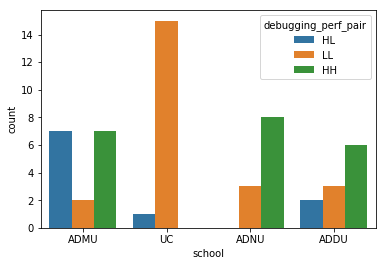

In [174]:
sns.countplot(x="school", hue="debugging_perf_pair", data=pair_df)

No assigned pairs with debugging performance level of HL for ADNU and HH for UC. This could be because of drops in observations due to erroneous rows assignments. Let's see it in the next diagram:

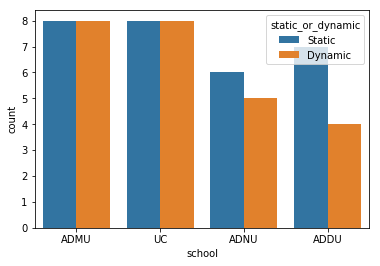

In [183]:
sns.countplot(x="school", hue="static_or_dynamic", data=pair_df)

A total of 5 and 4 observations dropped from ADNU and ADDU, respectively. It also seems that more observations were dropped in the Dynamic scenario. Now let's check the debugging score differences using a box plot!

Text(0,0.5,'debugging score difference')

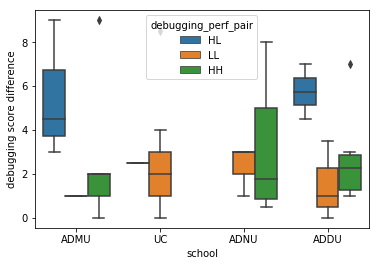

In [177]:
ax = sns.boxplot(x="school", y="debugging_scores", hue="debugging_perf_pair", data=pair_df)
ax.set_ylabel("debugging score difference")